In [1035]:
import json

In [1036]:
def get_scores_prompting(task, dataset, n_shot, base_path="../../zero-shot-absa-quad/generations/zeroshot/", data_type="test"):
    power, vram, times = [], [], []
    n_samples = 0

    for seed in range(5):
        file_path = f"{base_path}/{task}_{dataset}_{data_type}_gemma3:27b_{seed}{'_label' if data_type == 'test' else ''}_{n_shot}_PERFORMANCE.json"
        with open(file_path, "r") as f:
            data = json.load(f)
            n_samples += len(data)
            power.extend(ex["avg_gpu_power_eval_W"] for ex in data)
            vram.extend(ex["avg_gpu_vram_eval_MB"] for ex in data)
            times.extend(ex["total_time_eval"] for ex in data)

    return {
        "avg_gpu_power_eval_W": sum(power) / len(power),
        "avg_gpu_vram_eval_MB": sum(vram) / len(vram),
        "total_time_eval": sum(times) * 20 / 5 / 60,
        "n_samples": n_samples * 20 / 5,
        "kWH": ((sum(power) / len(power) * sum(times) * 20 / 5)) /(36 * 100)
    }

def get_scores_prompting_all(task, n_shot, base_path="../../zero-shot-absa-quad/generations/zeroshot/", data_type="test"):
    datasets = ["rest15", "rest16", "hotels", "coursera", "flightabsa"]
    all_stats = [get_scores_prompting(task, ds, n_shot, base_path, data_type) for ds in datasets]

    return {
        key: sum(stat[key] for stat in all_stats) / len(all_stats)
        for key in all_stats[0]
    }


In [1037]:
get_scores_prompting_all("asqp", 50), get_scores_prompting_all("asqp", 50, "../_out_synthetic_examples/01_llm_annotate_train", "train")

({'avg_gpu_power_eval_W': 245.23850078790178,
  'avg_gpu_vram_eval_MB': 19053.462272162396,
  'total_time_eval': 78.29607595125836,
  'n_samples': 448.0,
  'kWH': 319.92145010261487},
 {'avg_gpu_power_eval_W': 248.20905023283612,
  'avg_gpu_vram_eval_MB': 19132.56245612043,
  'total_time_eval': 182.2997937965393,
  'n_samples': 1192.0,
  'kWH': 754.4445856874171})

In [1038]:
def get_scores_laaa(
    task,
    dataset,
    n_shot,
    method,
    base_path="../_out_fine_tunings/01_llm_annotate_train",
):
    (
        avg_gpu_vram_train_MB,
        avg_gpu_power_train_W,
        total_time_eval,
        total_time_train,
        avg_gpu_vram_eval_MB,
        avg_gpu_power_eval_W,
    ) = ([], [], [], [], [], [])
    n_samples = 0

    for seed in range(5):
        file_path = f"{base_path}/{method}_full_{task}_{n_shot}_{dataset}_{seed}_PERFORMANCE.json"
        with open(file_path, "r") as f:
            data = json.load(f)
            n_samples += len(data["all_preds"])
            avg_gpu_vram_train_MB.append(data["avg_gpu_vram_train_MB"])
            avg_gpu_power_train_W.append(data["avg_gpu_power_train_W"])
            total_time_eval.append(data["total_time_eval"])
            total_time_train.append(data["total_time_train"])
            avg_gpu_vram_eval_MB.append(data["avg_gpu_vram_eval_MB"])
            avg_gpu_power_eval_W.append(data["avg_gpu_power_eval_W"])
    
    return {
        "avg_gpu_vram_train_MB": sum(avg_gpu_vram_train_MB) / 5,
        "avg_gpu_power_train_W": sum(avg_gpu_power_train_W) / 5,
        "total_time_eval": sum(total_time_eval) / 5 / 60 ,
        "total_time_train": sum(total_time_train) / 5 * 20 / 60,
        "avg_gpu_vram_eval_MB": sum(avg_gpu_vram_eval_MB) / 5,
        "avg_gpu_power_eval_W": sum(avg_gpu_power_eval_W) / 5,
        "n_samples_test": n_samples / 5,
        "kWH_train": (sum(avg_gpu_power_train_W) / 5 * sum(total_time_train) / 5 * 20 ) / (36 * 100),
        "kWH_eval": (sum(avg_gpu_power_eval_W) / 5 * sum(total_time_eval) / 5 ) / (36 * 100),
    }
    
def get_scores_laaa_all(
    task,
    n_shot,
    method,
    base_path="../_out_fine_tunings/01_llm_annotate_train",
):
    datasets = ["rest15", "rest16", "hotels", "coursera", "flightabsa"]
    all_stats = [get_scores_laaa(task, ds, n_shot, method, base_path) for ds in datasets]

    return {
        key: sum(stat[key] for stat in all_stats) / len(all_stats)
        for key in all_stats[0]
    }

In [1039]:
get_scores_laaa_all("asqp", 50, "paraphrase")

{'avg_gpu_vram_train_MB': 14845.52,
 'avg_gpu_power_train_W': 208.97767747277595,
 'total_time_eval': 0.5183886098861694,
 'total_time_train': 7.579542795817057,
 'avg_gpu_vram_eval_MB': 14845.52,
 'avg_gpu_power_eval_W': 135.38454238940716,
 'n_samples_test': 453.6,
 'kWH_train': 26.447060241915665,
 'kWH_eval': 1.17314534796971}

In [1040]:
def draw_plot(title_x, title_y, plot_title, data=[], maximum_y=1000, maximum_x=1000):
    import matplotlib.pyplot as plt
    from matplotlib import font_manager
    import numpy as np

    font_path = 'Manrope-Regular.ttf'
    font_manager.fontManager.addfont(font_path)
    prop = font_manager.FontProperties(fname=font_path)

    plt.rcParams['font.family'] = 'sans-serif'
    plt.rcParams['font.sans-serif'] = prop.get_name()
    plt.style.use('seaborn-v0_8-paper') 

    plt.figure(figsize=(6, 4), dpi=100)
    
    for d in data:
        x = np.array(d["x"])
        y = np.array(d["y"])
        
        plt.scatter([x[-1]], [y[-1]], color=d["line_color"], s=50, zorder=5)

        if x[1] > x[0]:
          N_TIMES_SCALE = 200   
          x[1] = x[1] * N_TIMES_SCALE
          y[1] = y[1] + (y[1] - y[0]) * (N_TIMES_SCALE-1)
         
        plt.plot(x, y, color=d["line_color"], linewidth=2, label=d["legend_title_line"])
        

    plt.xlabel(title_x, fontsize=11)
    plt.ylabel(title_y, fontsize=11)
    plt.title(plot_title, fontsize=12, pad=10)

    plt.grid(True, linestyle='--', alpha=0.7)
    plt.minorticks_on()

    plt.xlim(0, maximum_x)
    plt.ylim(0, maximum_y)

    # Add legend below the plot
    plt.legend(
        loc='upper center',
        bbox_to_anchor=(0.5, -0.15),
        ncol=2,
        fontsize=9,
        frameon=False
    )

    plt.tight_layout()
    plt.savefig("prediction_time_plot.pdf", format="pdf", dpi=300, bbox_inches="tight")
    plt.show()

In [1041]:
line_colors = {
    "dlo_10": "mediumseagreen",
    "dlo_50": "darkgreen",
    "paraphrase_10": "lightcoral",
    "paraphrase_50": "darkred",
    "gemma3:27b_10": "skyblue",
    "gemma3:27b_50": "darkblue",
}

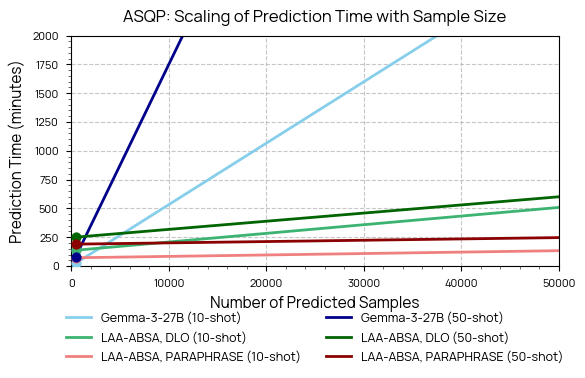

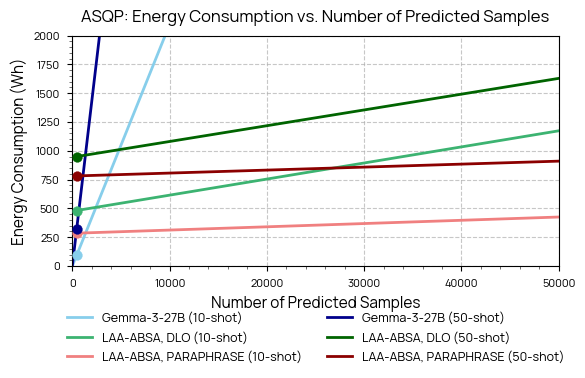

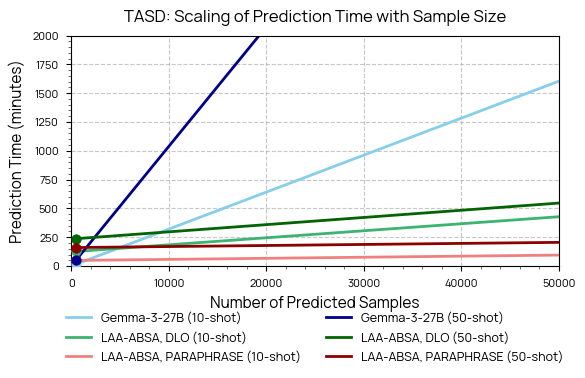

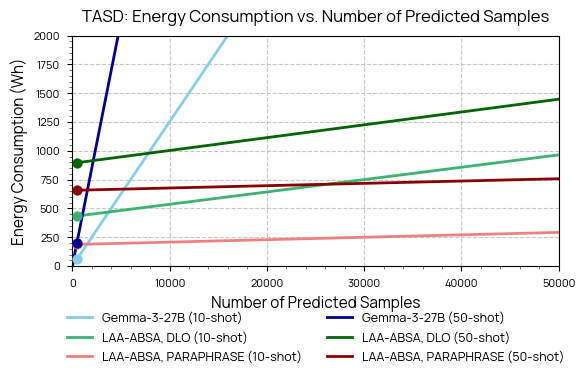

In [1042]:
for task in ["asqp", "tasd"]:
    # Function to get scores for different configurations
    def get_scores(shot_count, method=None, data_type=None):
        if method is None:
            # Standard prompting
            return get_scores_prompting_all(task, shot_count)
        elif method == "annotate":
            # LLM annotate train
            return get_scores_prompting_all(
                task,
                shot_count,
                base_path="../_out_synthetic_examples/01_llm_annotate_train",
                data_type="train",
            )
        else:
            # LAAA with specified method (paraphrase or dlo)
            return get_scores_laaa_all(task, shot_count, method)

    # Get scores for all configurations
    configurations = []
    for shot_count in [10, 50]:
        # Standard prompting
        configurations.append({
            "scores": get_scores(shot_count),
            "label": f"Gemma-3-27B ({shot_count}-shot)",
            "color": line_colors[f"gemma3:27b_{shot_count}"]
        })
        
        # LAAA with different methods
        for method in ["dlo", "paraphrase"]:
            annotate_scores = get_scores(shot_count, "annotate")
            method_scores = get_scores(shot_count, method)
            
            configurations.append({
                "scores": {
                    "annotate": annotate_scores,
                    "method": method_scores
                },
                "label": f"LAA-ABSA, {method.upper()} ({shot_count}-shot)",
                "color": line_colors[f"{method}_{shot_count}"]
            })

    # Draw prediction time plot
    plot_data = []
    for config in configurations:
        if "annotate" not in config["scores"]:
            # Standard prompting
            plot_data.append({
                "x": [0, config["scores"]["n_samples"]],
                "y": [0, config["scores"]["total_time_eval"]],
                "legend_title_line": config["label"],
                "line_color": config["color"],
            })
        else:
            # LAAA methods
            annotate = config["scores"]["annotate"]
            method = config["scores"]["method"]
            plot_data.append({
                "x": [0, method["n_samples_test"]],
                "y": [
                    annotate["total_time_eval"] + method["total_time_train"],
                    annotate["total_time_eval"] + method["total_time_train"] + method["total_time_eval"],
                ],
                "legend_title_line": config["label"],
                "line_color": config["color"],
            })
    
    draw_plot(
        "Number of Predicted Samples",
        "Prediction Time (minutes)",
        f"{task.upper()}: Scaling of Prediction Time with Sample Size",
        plot_data,
        maximum_y=2000,
        maximum_x=50000,
    )

    # Draw energy consumption plot
    plot_data = []
    for config in configurations:
        if "annotate" not in config["scores"]:
            # Standard prompting
            plot_data.append({
                "x": [0, config["scores"]["n_samples"]],
                "y": [0, config["scores"]["kWH"]],
                "legend_title_line": config["label"],
                "line_color": config["color"],
            })
        else:
            # LAAA methods
            annotate = config["scores"]["annotate"]
            method = config["scores"]["method"]

            plot_data.append({
                "x": [0, method["n_samples_test"]],
                "y": [
                    annotate["kWH"] + method["kWH_train"],
                    annotate["kWH"] + method["kWH_train"] + method["kWH_eval"],
                ],
                "legend_title_line": config["label"],
                "line_color": config["color"],
            })
    
    draw_plot(
        "Number of Predicted Samples",
        "Energy Consumption (Wh)",
        f"{task.upper()}: Energy Consumption vs. Number of Predicted Samples",
        plot_data,
        maximum_y=2000,
        maximum_x=50000,
    )